In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [26]:
df_train = pd.read_csv('train_bio.csv')
df_test = pd.read_csv('test_bio.csv')
df_train.drop(columns='Unnamed: 0',inplace=True)
df_test.drop(columns='Unnamed: 0',inplace=True)

In [27]:
X_train, y_train = df_train.drop(columns=['accuracy']), df_train['accuracy']
X_test, y_test = df_test.drop(columns=['accuracy']), df_test['accuracy']

### 1.1) Try Logistic Regression with all features (full set of categorical features)

In [28]:
# helper function to get cross-validation results
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

def show_cv_results(model, x, y, cv=10):
    scores = cross_validate(model, x, y, cv=cv, return_train_score=True)
    print("Mean test score:", scores["test_score"].mean()) # mean test accuracy score
    display(pd.DataFrame(scores))

In [29]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")

show_cv_results(lr, X_train, y_train)

Mean test score: 0.6739040200649993


,fit_time,score_time,test_score,train_score
0,0.944471,0.139078,0.679525,0.856766
1,0.799432,0.126259,0.661721,0.858086
2,0.714139,0.121319,0.655786,0.853795
3,0.695193,0.109311,0.682493,0.853465
4,0.734560,0.109162,0.635015,0.854125
5,0.725229,0.103740,0.685460,0.858086
6,0.695668,0.093111,0.682493,0.852145
7,0.705234,0.079321,0.675595,0.853184
8,0.737890,0.097647,0.684524,0.846915
9,0.816456,0.087526,0.696429,0.856813


In [30]:
show_cv_results(lr, X_test, y_test)

Mean test score: 0.6660344827586208


,fit_time,score_time,test_score,train_score
0,0.344747,0.096326,0.641379,0.873652
1,0.390398,0.153308,0.641379,0.872111
2,0.368974,0.148950,0.627586,0.872111
3,0.454327,0.099981,0.659722,0.872209
4,0.367053,0.084486,0.652778,0.878368
5,0.382469,0.102079,0.618056,0.872209
6,0.502911,0.156287,0.743056,0.862202
7,0.400992,0.104243,0.694444,0.871440
8,0.465356,0.136229,0.680556,0.862202
9,0.445497,0.107913,0.701389,0.866051


In [31]:
# Performance on the test set

def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

### 1.2) Hyperparameter Tuning for Logistic Regression

In [32]:
# https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
}
lr = LogisticRegression(max_iter=10000, solver='liblinear')
clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [33]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")

In [34]:
report_GridSearchCV_results(clf)

Best combination of hyperparams:
 {'C': 0.1, 'penalty': 'l2'} 

Best mean_test_score score:
 0.6783630069238378 

Score by fold for best estimator:
 [0.6735905044510386, 0.6795252225519288, 0.6468842729970327, 0.6617210682492581, 0.6528189910979229, 0.7002967359050445, 0.685459940652819, 0.6845238095238095, 0.6815476190476191, 0.7172619047619048] 



              precision    recall  f1-score   support

           0       0.71      0.90      0.79       959
           1       0.56      0.26      0.35       484

    accuracy                           0.68      1443
   macro avg       0.63      0.58      0.57      1443
weighted avg       0.66      0.68      0.64      1443



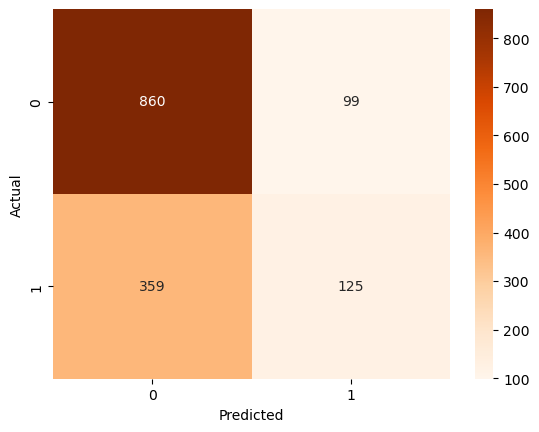

In [35]:
score_model(clf, X_test, y_test)

### 2.1) RandomForest Baseline Model with all features

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)
        
y_train_pred = clf.predict(X_train)
print('Training Accuracy: ', metrics.accuracy_score(y_train, y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print()
y_test_pred = clf.predict(X_test)
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

Training Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2236
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      3367
   macro avg       1.00      1.00      1.00      3367
weighted avg       1.00      1.00      1.00      3367

[[2236    0]
 [   0 1131]]

Test Accuracy:  0.6729036729036729
              precision    recall  f1-score   support

           0       0.69      0.94      0.79       959
           1       0.54      0.15      0.24       484

    accuracy                           0.67      1443
   macro avg       0.62      0.54      0.51      1443
weighted avg       0.64      0.67      0.61      1443

[[898  61]
 [411  73]]


### 2.2) Hyperparameter tuning for RandomForest

#### RandomizedSearchCV

In [37]:
# randomised search

from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

distributions = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = distributions, cv = 3, n_jobs = 2)
rf_random.fit(X_train, y_train)

report_GridSearchCV_results(rf_random)

Best combination of hyperparams:
 {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 90, 'bootstrap': False} 

Best mean_test_score score:
 0.6792385644724442 

Score by fold for best estimator:
 [0.6829919857524488, 0.6711229946524064, 0.6836007130124777] 



              precision    recall  f1-score   support

           0       0.69      0.92      0.79       959
           1       0.55      0.20      0.29       484

    accuracy                           0.68      1443
   macro avg       0.62      0.56      0.54      1443
weighted avg       0.64      0.68      0.62      1443



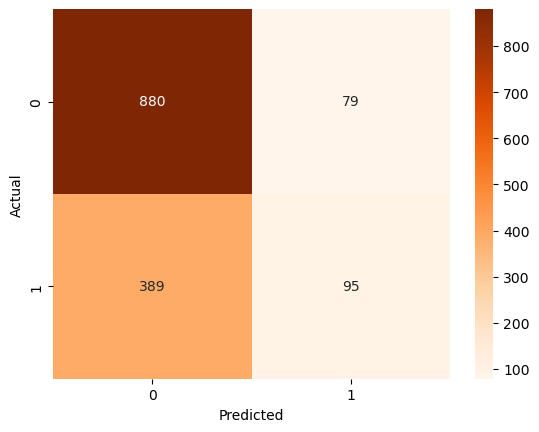

In [38]:
score_model(rf_random, X_test, y_test)

In [39]:
rf = RandomForestClassifier(n_estimators= 1200, min_samples_split=10, min_samples_leaf = 4, max_depth = 60)
rf.fit(X_train,y_train)
sorted_idx = rf.feature_importances_.argsort()
feature_names=X_train.columns

In [40]:
feature_names.__len__()

8018

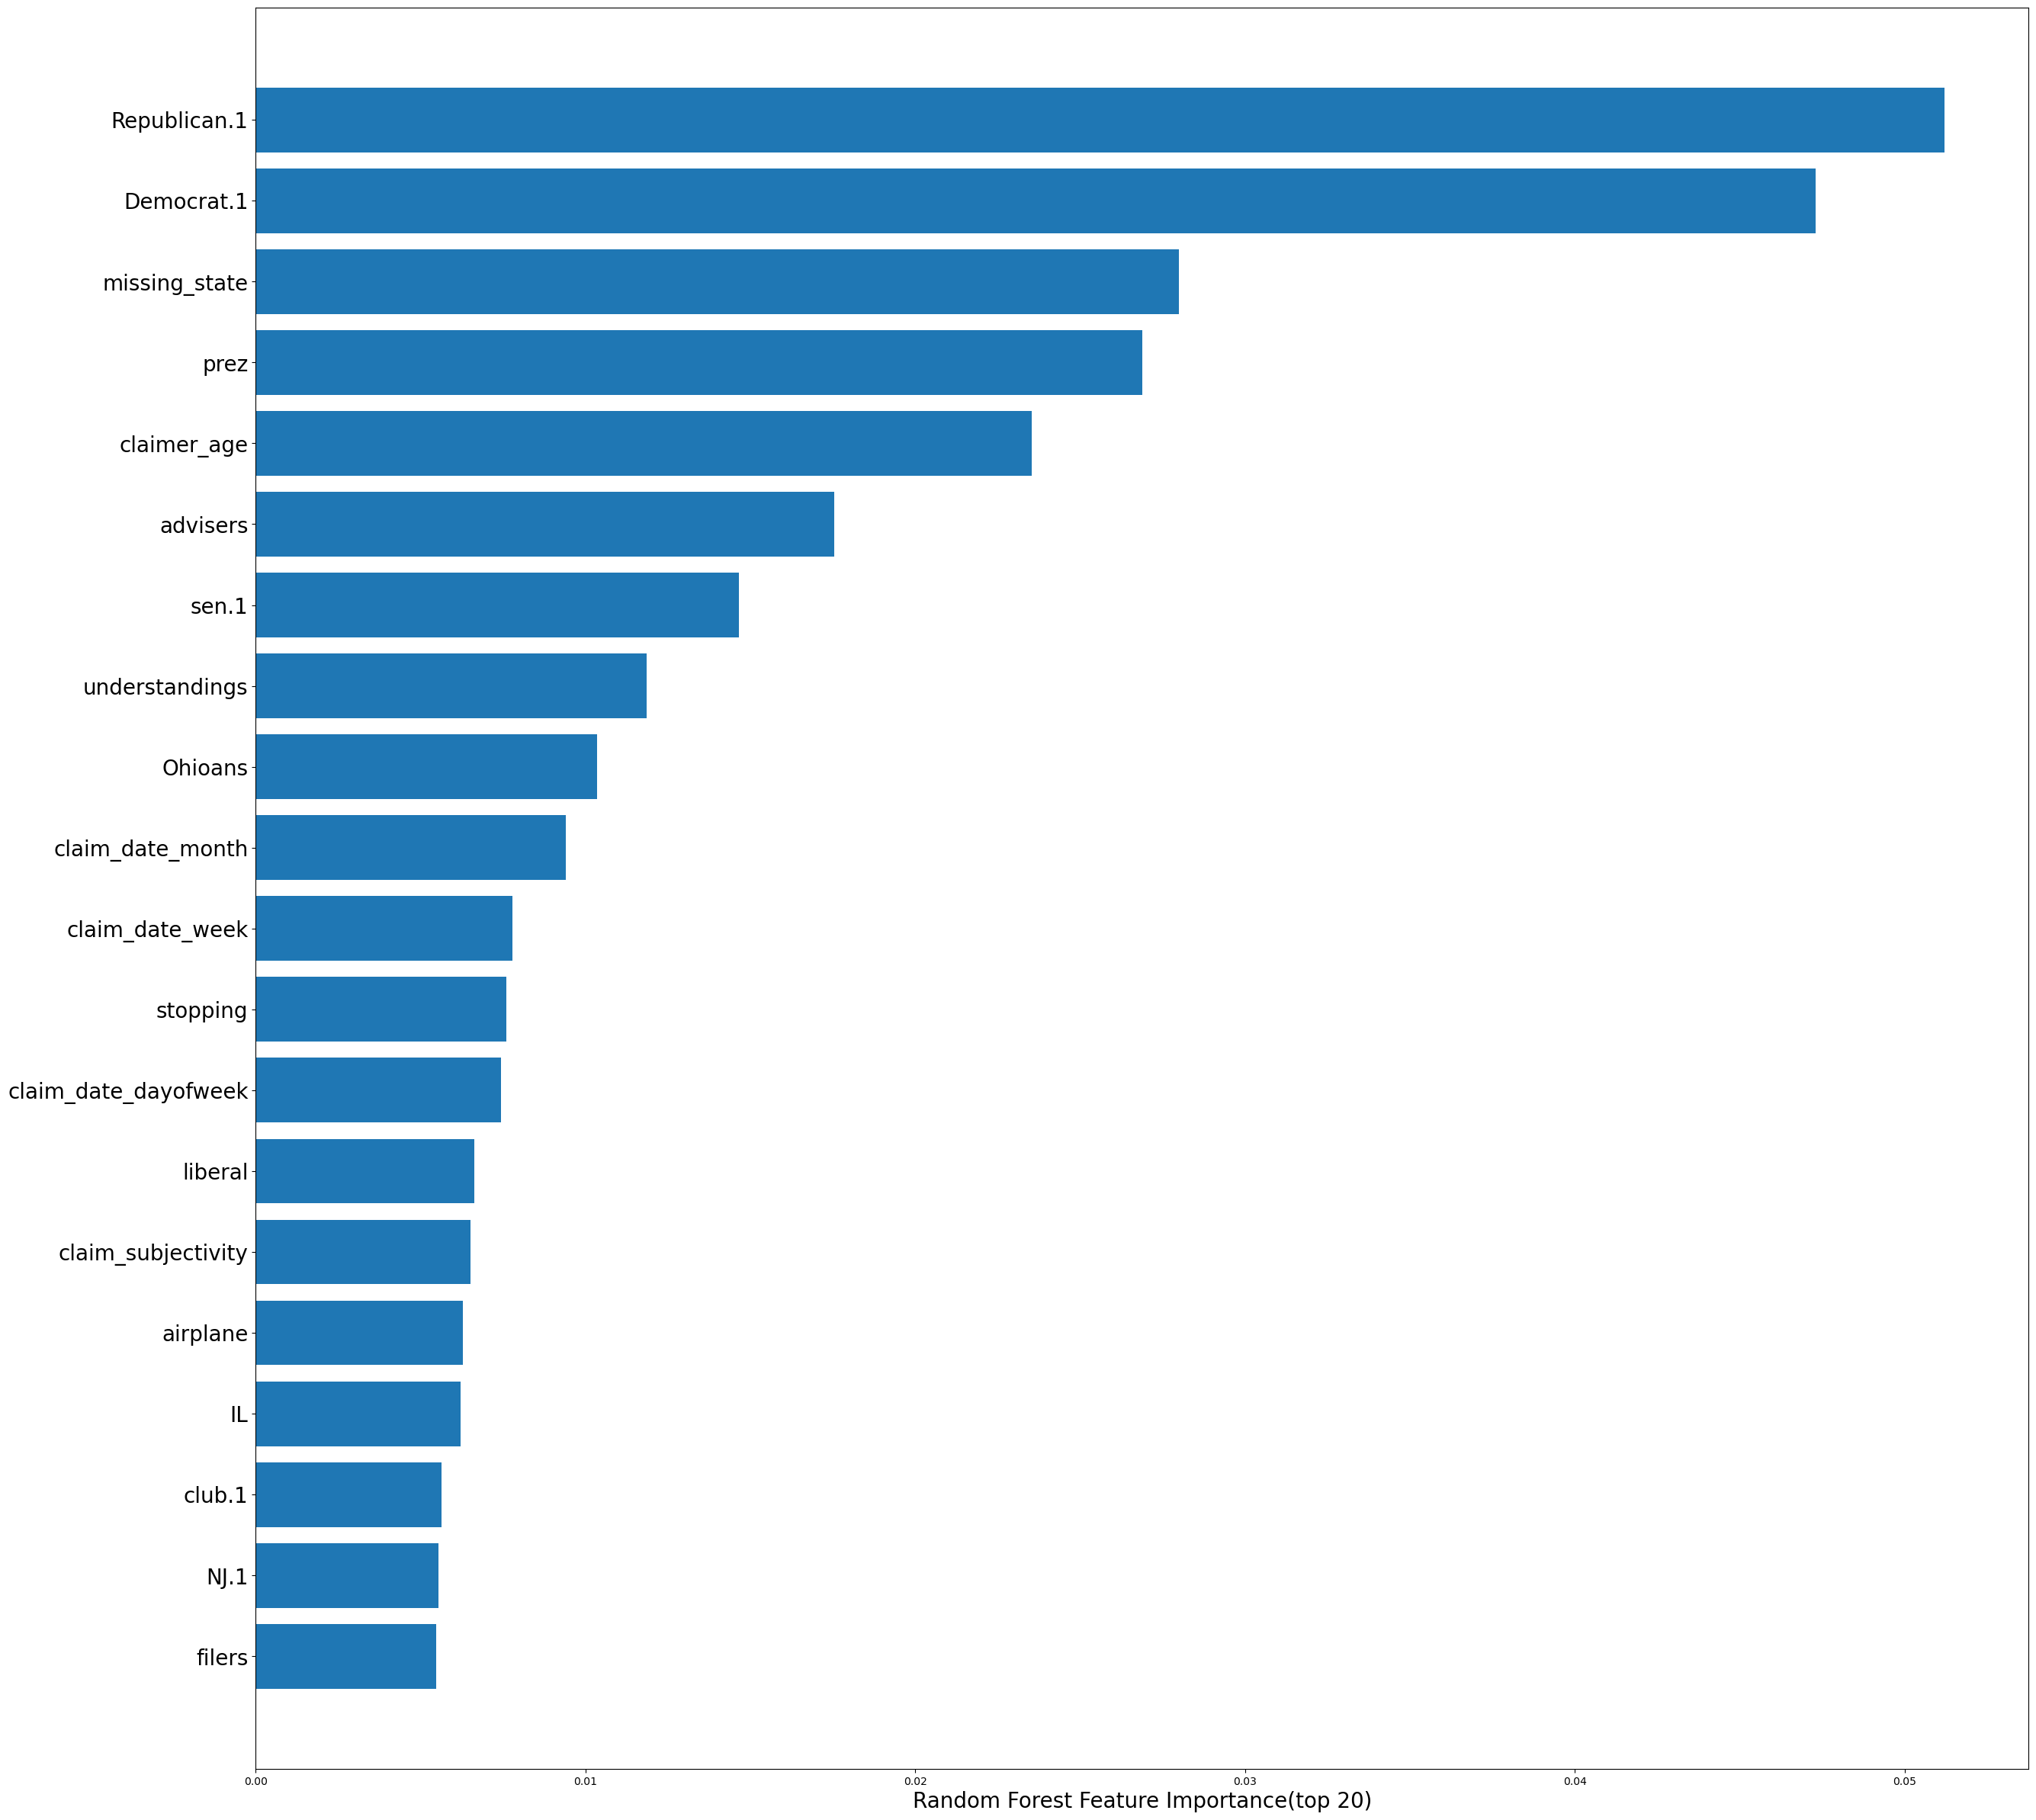

In [41]:
fig, axes = plt.subplots(figsize=(30,30))
plt.barh(feature_names[sorted_idx][feature_names.__len__()-20:],rf.feature_importances_[sorted_idx][feature_names.__len__()-20:])
plt.xlabel("Random Forest Feature Importance(top 20)", fontdict={'size':20})
plt.yticks(font={'size':20})
plt.show()

#### GridSearchCV

In [42]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
grid_rf = {
    "max_depth": [5, 50, 75, 100],
    'min_samples_split': [12, 16, 20],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(estimator = rf,      # model
                   param_grid = grid_rf,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 50, 75, 100],
                         'min_samples_split': [12, 16, 20]},
             scoring='accuracy')

In [43]:
report_GridSearchCV_results(rf_grid)

Best combination of hyperparams:
 {'criterion': 'entropy', 'max_depth': 75, 'min_samples_split': 12} 

Best mean_test_score score:
 0.6848823654090717 

Score by fold for best estimator:
 [0.6913946587537092, 0.6884272997032641, 0.685459940652819, 0.6973293768545994, 0.6765578635014837, 0.6646884272997032, 0.6913946587537092, 0.6785714285714286, 0.6964285714285714, 0.6785714285714286] 



              precision    recall  f1-score   support

           0       0.68      0.96      0.79       959
           1       0.56      0.11      0.19       484

    accuracy                           0.67      1443
   macro avg       0.62      0.53      0.49      1443
weighted avg       0.64      0.67      0.59      1443



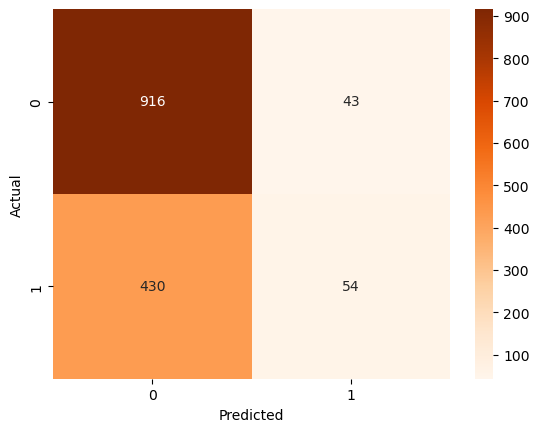

In [44]:
# performance on test set
rf = RandomForestClassifier(random_state=42,max_depth=50,min_samples_split=20)
rf.fit(X_train, y_train)
score_model(rf,X_test,y_test)

### 3) Gradient Boosting

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1,random_state = 42) # max_features=5

gbc.fit(X_train, y_train)

print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

0.8402138402138403
0.6645876645876646


In [46]:
# randomised search for GB

params = {'learning_rate':[0.01,0.05,0.1],
'n_estimators':np.arange(100,500,100)}

search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), params, random_state=42, cv=3)

gb_rand_search = search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % gb_rand_search.best_params_)
print('Best Score: %s' % gb_rand_search.best_score_)

Best Hyperparameters: {'n_estimators': 400, 'learning_rate': 0.05}
Best Score: 0.670628817111453
